In [1]:
! pip install btester requests tqdm yfinance QuantStats

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import yfinance as yf
import pandas as pd
import requests

start = '2006-01-01'
end = '2024-01-01'

assets = 'nasdaq100'
benchmark = 'NQ=F'

ldf = pd.read_html(requests.get(f'https://www.slickcharts.com/{assets}', headers={'User-agent': 'Mozilla/5.0'}).text)
symbols = [x.replace('.','-') for x in ldf[0]['Symbol'] if isinstance(x, str)]
downloads = yf.download([*symbols, benchmark], start, end, group_by='ticker')

data = downloads[symbols]
benchmark = downloads[benchmark]['Close']

[*********************100%%**********************]  102 of 102 completed


In [4]:
from btester import Strategy

def EMA(ser: pd.Series, period: int):
    return ser.ewm(span=period, adjust=False).mean().values

class MACrossoverStrategy(Strategy):
    buy_at_once_size = .05 # 5%

    def init(self, fast_period: int, slow_period: int):
        self.fast_ma = {}
        self.slow_ma = {}

        for symbol in self.symbols:
            self.fast_ma[symbol] = EMA(self.data[(symbol,'Close')], fast_period)
            self.slow_ma[symbol] = EMA(self.data[(symbol,'Close')], slow_period)

    def next(self, i, record):
        for symbol in self.symbols:
            if self.fast_ma[symbol][i-1] > self.slow_ma[symbol][i-1]:
                self.open(symbol=symbol, price=record[(symbol,'Open')], size=self.positionSize(record[(symbol,'Open')]))

        for position in self.open_positions[:]:
            if self.fast_ma[position.symbol][i-1] < self.slow_ma[position.symbol][i-1]:
                self.close(position=position, price=record[(position.symbol,'Open')])

    def positionSize(self, price: float):
        return round((self.cash + self.assets_value) / price * self.buy_at_once_size) if price > 0 else 0

In [5]:
from btester import Backtest
backtest = Backtest(MACrossoverStrategy, data, commission=.001, cash=1e6)

In [6]:
import quantstats as qs
from itertools import product
from tqdm.contrib.concurrent import process_map

parameters = ['Fast MA','Slow MA']
values = [[5, 10, 15, 20, 25], [30, 35, 40, 45, 50]]

def run(v):
    result = backtest.run(*v)
    returns = result.returns
    return [*v, returns.iloc[0], returns.iloc[-1], qs.stats.max_drawdown(returns) * 100, qs.stats.cagr(returns) * 100, qs.stats.sharpe(returns)]

optimization_results = process_map(run, list(product(*values)))
optimization_results = pd.DataFrame(optimization_results, columns=[*parameters,'Initial Capital','Cumulative Return','Max Drawdown (%)','CAGR (%)','Sharpe Ratio'])
optimization_results.set_index([*parameters], inplace=True)

100%|██████████| 25/25 [00:04<00:00,  5.42it/s]


In [7]:
optimization_results_sorted = optimization_results.sort_values('Sharpe Ratio', ascending=False)
optimization_results_sorted

Initial Capital  Cumulative Return  Max Drawdown (%)  \
Fast MA Slow MA                                                         
25      45          1.015252e+06       1.184697e+08        -52.580783   
20      50          1.015252e+06       7.770688e+07        -51.967042   
25      50          1.014088e+06       7.640193e+07        -54.989720   
15      50          1.015252e+06       7.027217e+07        -47.625498   
5       35          1.015146e+06       6.714917e+07        -47.535229   
        30          1.014175e+06       6.062768e+07        -51.700175   
15      40          1.015252e+06       6.564490e+07        -49.193819   
25      40          1.015252e+06       6.382035e+07        -52.464655   
20      30          1.015252e+06       6.106837e+07        -51.814845   
10      30          1.015146e+06       5.827959e+07        -44.926183   
        45          1.015252e+06       5.375004e+07        -46.076517   
15      30          1.015252e+06       5.443089e+07        -49.088717   
20      45          1.015252e+06       5.448338e+07        -52.404297   
10      50          1.015252e+06       5.207537e+07        -47.277078   
5       50          1.015252e+06       4.980623e+07        -43.492384   
        40          1.015146e+06       5.066004e+07        -44.798905   
        45          1.015146e+06       4.880953e+07        -41.391171   
10      40          1.015252e+06       4.892907e+07        -49.053472   
25      35          1.015252e+06       4.776390e+07        -49.319945   
20      40          1.015252e+06       4.894774e+07        -49.877813   
15      45          1.015252e+06       5.019428e+07        -48.405694   
20      35          1.015252e+06       4.248934e+07        -53.870343   
15      35          1.015252e+06       4.087461e+07        -50.848524   
10      35          1.015146e+06       3.600943e+07        -47.940810   
25      30          1.015252e+06       3.499743e+07        -53.057629   

                  CAGR (%)  Sharpe Ratio  
Fast MA Slow MA                           
25      45       30.272476      1.153873  
20      50       27.255405      1.078515  
25      50       27.143814      1.067574  
15      50       26.546290      1.054523  
5       35       26.227783      1.044506  
        30       25.519930      1.043823  
15      40       26.068244      1.040041  
25      40       25.870946      1.033258  
20      30       25.563046      1.020204  
10      30       25.238086      1.018777  
        45       24.675613      1.018241  
15      30       24.762843      1.016160  
20      45       24.769525      1.008138  
10      50       24.456534      1.003840  
5       50       24.148824      1.002430  
        40       24.266854      1.001179  
        45       24.010180      0.998145  
10      40       24.026315      0.995406  
25      35       23.860334      0.985193  
20      40       24.028944      0.983659  
15      45       24.202373      0.981184  
20      35       23.057615      0.940243  
15      35       22.792983      0.937212  
10      35       21.932079      0.928696  
25      30       21.738393      0.915524

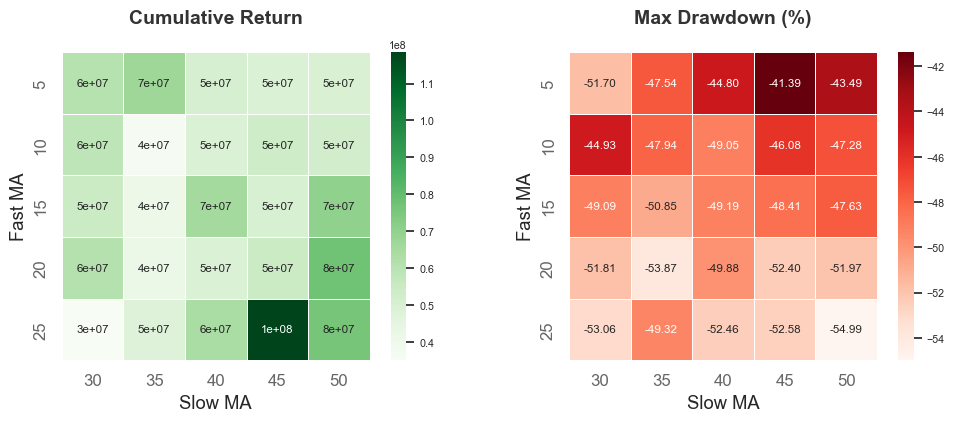

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].set_title('Cumulative Return\n', fontsize=14, fontweight='bold')
ax[1].set_title('Max Drawdown (%)\n', fontsize=14, fontweight='bold')

reshape = lambda d: pd.DataFrame(d.values.reshape(len(d.index.levels[0]), len(d.index.levels[1])), d.index.levels[0], d.index.levels[1])

sns.set(font_scale=.7)
sns.heatmap(reshape(optimization_results['Cumulative Return']), ax=ax[0], annot=True, fmt='.0g', linewidth=.5, square=True, cmap='Greens')
sns.heatmap(reshape(optimization_results['Max Drawdown (%)']), ax=ax[1], annot=True, fmt='.2f', linewidth=.5, square=True, cmap='Reds')

plt.show()

In [9]:
best_params = optimization_results_sorted.index[0]
best_params

(25, 45)

In [10]:
result = backtest.run(*best_params)

In [11]:
import quantstats as qs
qs.reports.metrics(result.returns, benchmark)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2006-01-03  2006-01-03
End Period          2023-12-29  2023-12-29
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   11,568.99%  905.52%
CAGR﹪              30.27%      13.68%

Sharpe              1.15        0.69
Prob. Sharpe Ratio  100.0%      99.82%
Sortino             1.7         0.97
Sortino/√2          1.2         0.69
Omega               1.23        1.23

Max Drawdown        -52.58%     -53.85%
Longest DD Days     1002        1161

Gain/Pain Ratio     0.23        0.14
Gain/Pain (1M)      1.73        0.83

Payoff Ratio        0.96        0.86
Profit Factor       1.23        1.14
Common Sense Ratio  1.21        1.04
CPC Index           0.65        0.54
Tail Ratio          0.98        0.92
Outlier Win Ratio   3.71        4.63
Outlier Loss Ratio  3.65        4.21

MTD                 7.2%        6.49%
3M                  12.69%      1

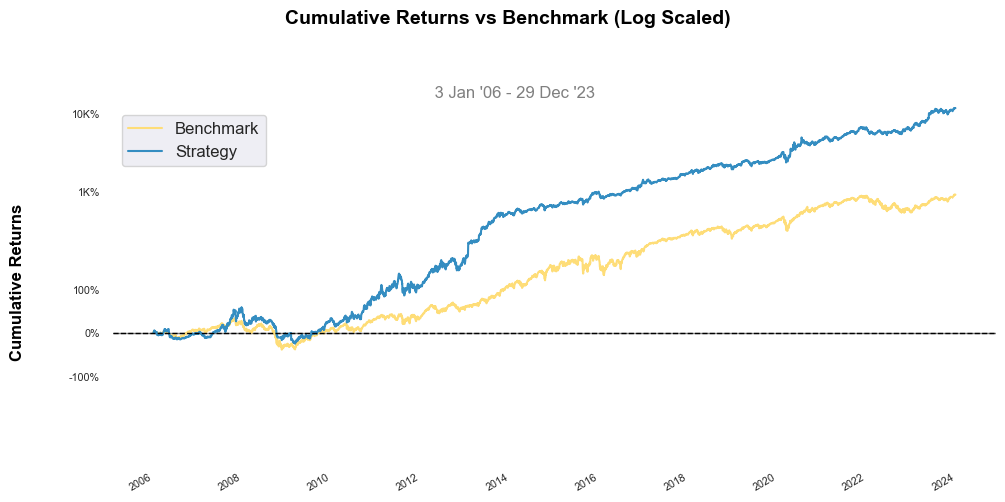

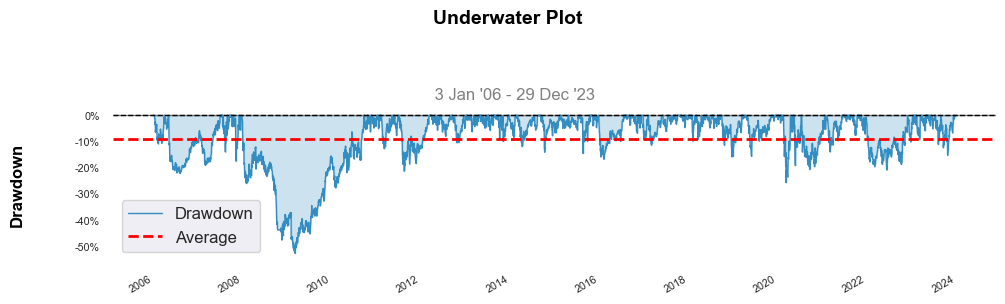

In [12]:
qs.plots.log_returns(result.returns, benchmark, fontname='sans-serif')
qs.plots.drawdown(result.returns, figsize=(10,3), fontname='sans-serif')

In [13]:
trades = pd.DataFrame(result.trades)
trades

,symbol,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
0,AMZN,2006-01-03,2006-01-05,2.373500,2.358000,21064,-326.493446,-0.653047,99.664319,9.995738e+05
1,ADBE,2006-01-03,2006-01-05,37.200001,38.259998,1344,1424.636719,2.849456,101.418239,1.000897e+06
2,PEP,2006-01-03,2006-01-05,59.919998,59.610001,834,-258.537964,-0.517352,99.688019,1.000539e+06
3,NFLX,2006-01-03,2006-01-05,3.865714,3.552857,12928,-4044.617249,-8.093127,95.907286,9.963983e+05
4,AMGN,2006-01-03,2006-01-05,79.360001,79.910004,630,346.501923,0.693048,100.340103,9.966445e+05
...,...,...,...,...,...,...,...,...,...,...
1141,GOOGL,2023-08-21,2023-11-01,127.180000,124.070000,41275,-128365.275192,-2.445354,10370.343750,1.003877e+08
1142,GOOGL,2023-10-03,2023-11-01,133.940002,124.070000,40020,-394997.509918,-7.368973,10325.560285,9.998239e+07
1143,GOOG,2023-10-03,2023-11-01,134.929993,125.339996,39724,-380953.014526,-7.107387,10338.965044,9.959110e+07
1144,GOOGL,2023-10-04,2023-11-01,132.789993,124.070000,39858,-347561.504562,-6.566755,10237.925600,9.923330e+07


In [14]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value
0,META,2023-03-13,2023-12-29,177.960007,353.959991,19734,3.473184e+06,98.898617,6.985046e+06
1,META,2023-08-21,2023-12-29,283.450012,353.959991,18521,1.305915e+06,24.875631,6.555693e+06
2,META,2023-09-27,2023-12-29,300.450012,353.959991,17154,9.179102e+05,17.809944,6.071830e+06
3,META,2023-10-03,2023-12-29,304.260010,353.959991,17619,8.756640e+05,16.334707,6.236421e+06
4,COST,2023-10-03,2023-12-29,571.099976,660.080017,9385,8.350777e+05,15.580467,6.194851e+06
5,ADBE,2023-10-03,2023-12-29,517.520020,596.599976,10356,8.189520e+05,15.280560,6.178389e+06
6,TMUS,2023-10-03,2023-12-29,138.759995,160.330002,38618,8.329905e+05,15.544831,6.191624e+06
7,META,2023-10-04,2023-12-29,298.730011,353.959991,17719,9.786200e+05,18.488260,6.271817e+06
8,MSFT,2023-10-23,2023-12-29,325.470001,376.040009,16076,8.129634e+05,15.537533,6.045219e+06
9,AVGO,2023-10-23,2023-12-29,857.960022,1116.250000,6098,1.575052e+06,30.105130,6.806892e+06
